#**Applied AI for Health Research**

#Practical 7: Interpretability

Tutorial by Cher Bass and Emma Robinson. Edited by Mariana da Silva.

In this notebook we will go through several popular visualization techniques that help interpret deep learning networks.

We will cover:
1. Filter visualization
2. Feature/ activation visualisation with PyTorch hooks
3. CNN Layer Visualisation
4. Gradient visualisation with Guided backpropagation
5. Gradient Class Activation Maps (Grad-CAM)

### Importing

The first thing we need to do is import a package called `visualizations`. 

In [13]:
!wget -nv https://github.com/IS-pillar-3/datasets/raw/main/visualizations.zip

from zipfile import ZipFile 
with ZipFile("visualizations.zip", "r") as zObject:
  zObject.extractall(path=".")                                   

2023-02-19 01:03:08 URL:https://raw.githubusercontent.com/IS-pillar-3/datasets/main/visualizations.zip [560571/560571] -> "visualizations.zip" [1]


Now import the modules you need from torch and the visualization package by running the cell below.

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, models, transforms

import torchvision.datasets as datasets
import torchvision.models as models

import numpy as np 
import visualizations
from visualizations.src.misc_functions import *
from visualizations.src.guided_backprop import GuidedBackprop
from visualizations.src.gradcam import GradCam
from visualizations.src.deep_dream import DeepDream


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Exercise 1: Weights Visualization


One of the first things you can visualize in your network is your networks weight tensors. These weights kernels reflect the learnt convolutional kernesl which are optimised during training. They can be visualized by calling the weight data inside your network.

Let's first load and print a pretrained network using pytorch.models:

In [15]:
# first load pretrained alxenet model
alexnet = models.alexnet(weights='DEFAULT')
print(alexnet)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

We can see from the print output (above) that the network is made up of two sequential containers: 1) `features` (the convolutional layers) and 2) `classifier` (the linear layers).

To visualize the convolutional weights for some layer of a specific seqential container (e.g. `container`) of a network (e.g. `net`) we must use the following notation:

```python 
# to return layer
layer=net.container[layer_num]
 # to return weights tensor of a layer
weight_tensor = net.container[layer_num].weight.data
```

**Note that layer id `layer_num` should correspond to a *convolutional* layer (e.g. 0, 3, 6, 10) otherwise there are no weights to be visualized.**

We will now define a few functions to help with plotting:

In [16]:
def plot_filters_single_channel(t,channels_to_plot,kernels_to_plot):
    

    print('printing {} kernels for each of the first {} filters '.format(kernels_to_plot,channels_to_plot))
    #total kernels depth * number of kernels
    nplots = channels_to_plot*kernels_to_plot
    ncols = 12
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    #looping through all the kernels in each channel
    for i in range(kernels_to_plot):
        for j in range(channels_to_plot):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()    

    
def plot_filters_multi_channel(t,kernels_to_plot=60):
    
    print('printing the first {} 3D filters in RGB '.format(kernels_to_plot))
    #get the number of kernals
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = kernels_to_plot // num_cols+1
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    #looping through all the kernels
    for i in range(kernels_to_plot):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.tight_layout()
    plt.show()

We next define our plot weights function, which first extracts the weights of a convolutional filter, and then passes into an appropriate image plotting function.


### Ex 1.1 - Plot the weights of AlexNet

Using the generic example given above,  edit the function `plot_weights` function to return the weights tensor for a given convolutional layer:

**Task 1.1.1.** Select the convolutional `layer` from alexnets `features` container corresponding to `layer_num`.

**Task 1.1.2.** Return the `weight_tensor` for this layer.

**Task 1.1.3.** Run this function to return features from  `layer_num = 0`.

In [17]:
def plot_weights(container, layer_num,num_filter=10,num_kernels=30):
    '''
    plot_weights: a function to plot weights tensors from a network
                  this will print in RGB if filter depth is 3 (i.e. first layer)
                  else will print each kernel separately
    inputs:
          container: a sequnetial container for which the convolutional layers of the network are defined
          layer_num: choice of layer to visualise

    '''
    #STUDENTS CODE - REPLACE NONES in FUNCTION BELOW
    # 1.1.1. use variable layer_num to select a specific 
    layer = container[layer_num]
  
    #checking whether the layer is convolution layer or not 
    if isinstance(layer, nn.Conv2d):
        # 1.1.2. return the weights tensor for this 'layer`
        weight_tensor = layer.weight.data
        print('This layers learns {} filters each with {} kernels'.format(weight_tensor.shape[0],weight_tensor.shape[1]))
        # if the weights tensor has 3 channels the it will plot filters in RGB
        if weight_tensor.shape[1]==3:
             # labelling each by filer id            
             plot_filters_multi_channel(weight_tensor,num_filter)    
        else:
            # else it will print each filter kernel separately
            # labelling each by filer.kernel (the filter id and the kernel id)
            plot_filters_single_channel(weight_tensor,num_filter,num_kernels)
        
    else:
        print("Can only visualize layers which are convolutional")

This layers learns 64 filters each with 3 kernels
printing the first 60 3D filters in RGB 


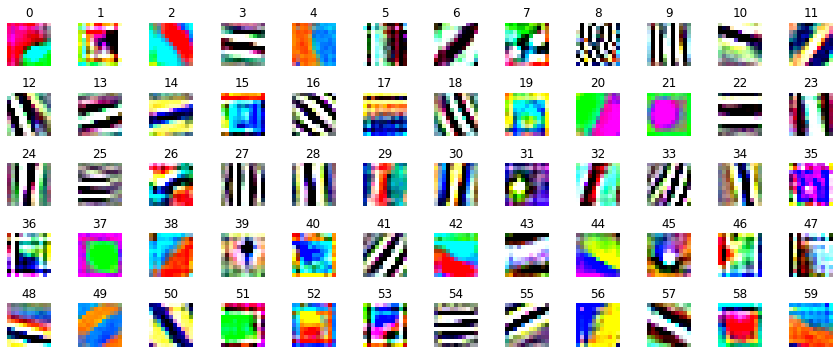

In [18]:
# 1.1.3. Call the function to visualise layer 0 (first conv layer)
plot_weights(alexnet.features, 0, 60)

###Ex 1.2 - Answer the following questions

**Task 1.2.1.** What do the weights of your network represent? (Answer in the cell below)

In [19]:
# Weights are the learnable parameters of the network

**Task 1.2.2.** Layer 3 (the second convolution) has a weights matrix of size `[192, 64, 5, 5]`. What does each dimension represent? How many filters does it learn, and how many kernels does each filter have?


In [ ]:
# the kernel sie is 5. it learns 192 filters, each with 64 kernels

**Task 1.2.3** Try plotting the weights for different convolutional layers (changing code cell below). 

This layers learns 192 filters each with 64 kernels
printing 20 kernels for each of the first 10 filters 


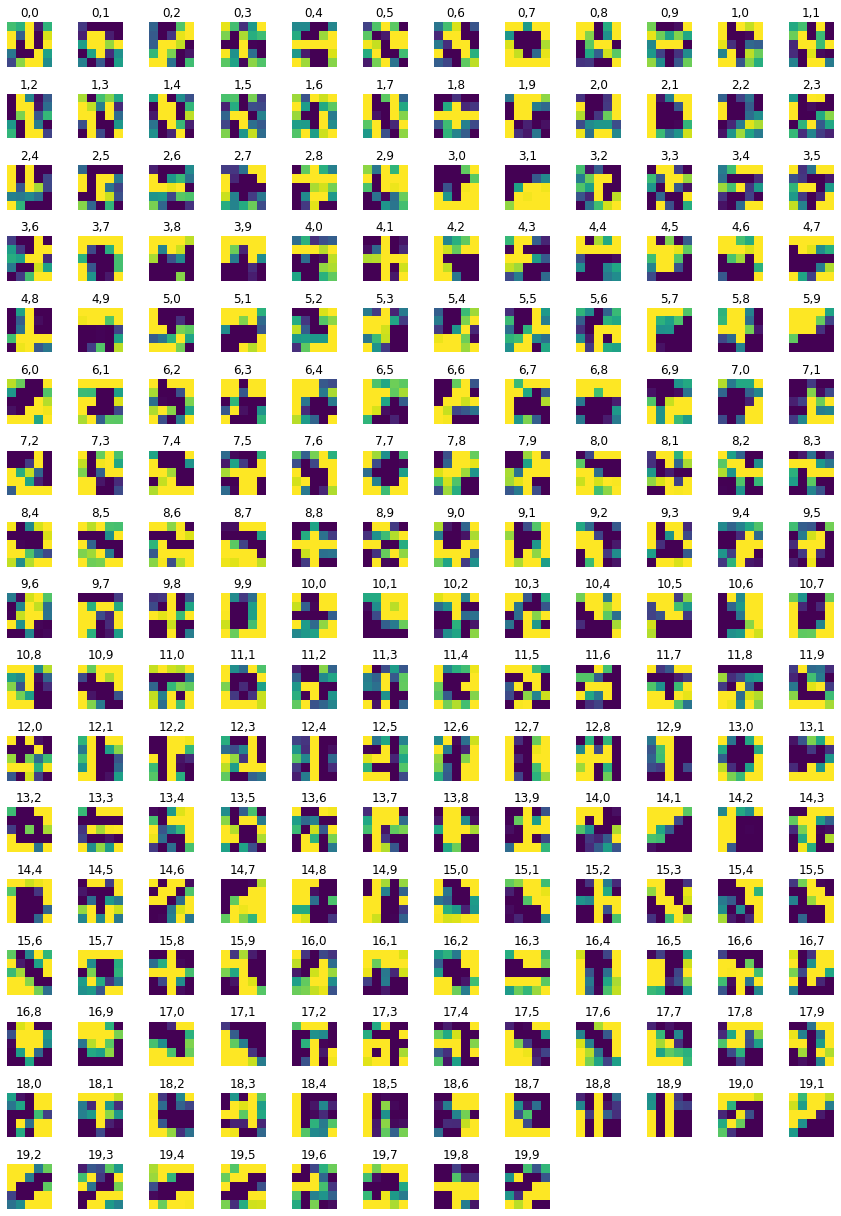

In [20]:
# Task 1.2.3 
plot_weights(alexnet.features, 3, 10, 20)

   - Try changing the numbers of filters and/or kernels printed per layer
   - What if anything can you interpret from each of these layer?
   - Do you think this approach is useful for intrepretation of deep networks? Why do you think that?
   

## Exercise 2: Saliency by Occlusion

Saliency mapping techniques seek to generate heatmaps which highlight which parts of an image are important for activation.

The most simple approach to saliency mapping is to perform occlusion. This works by greying out (setting to 0.5) patches of pixels for an image to see what impact this has on classification. 


Let's use MNIST for this example. Loading train and validation DataLoaders, and generating a similar basic convolutional network to which we used in Session 4:

In [21]:
mnist_train_dataset = datasets.MNIST(root = 'mnist_data/train', download= True, train = True, transform = transforms.ToTensor())
mnist_test_dataset = datasets.MNIST(root = 'mnist_data/test', download= True, train = False, transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(
       mnist_train_dataset, batch_size= 8, shuffle = True)

test_loader = torch.utils.data.DataLoader(
       mnist_test_dataset, batch_size = 8, shuffle = True)

classes = ('0', '1', '2', '3',
          '4', '5', '6', '7', '8', '9')

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist_data/train/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/train/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist_data/train/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/train/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist_data/train/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/train/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist_data/train/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/train/MNIST/raw



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist_data/test/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/test/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist_data/test/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/test/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist_data/test/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/test/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist_data/test/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/test/MNIST/raw



In [23]:
class MNIST_Model(nn.Module):
    def __init__(self):
        super(MNIST_Model, self).__init__()
    
        self.conv1=nn.Conv2d(1, 10, 3)
        self.maxpool1=nn.MaxPool2d(2)
        self.dropout1=nn.Dropout2d()
        
        self.conv2=nn.Conv2d(10, 20, 3)
        self.maxpool2=nn.MaxPool2d(2)
        self.dropout2=nn.Dropout2d()
        
        self.lin_blocks = nn.Sequential(
            nn.Linear(500, 50),
            nn.ReLU(),
            nn.Linear(50, 10),
        )
        
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        
        x = x.view(x.size(0),-1)
        x = self.lin_blocks(x)

        return F.log_softmax(x,dim=1)


net = MNIST_Model() 
print(net)
net = net.to(device)

loss_fun = nn.CrossEntropyLoss()
loss_fun = loss_fun.to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

epochs = 1
for epoch in range(epochs): 

    # enumerate can be used to output iteration index i, as well as the data 
    for i, (data, labels) in enumerate(train_loader, 0):
        
        # load data and labels to device
        data = data.to(device)
        labels = labels.to(device)
        
        # clear the gradient
        optimizer.zero_grad()

        #feed the input and acquire the output from network
        outputs = net(data)

        # calculating the predicted and the expected loss
        loss = loss_fun(outputs, labels)

        #compute the gradient
        loss.backward()

        #update the parameters
        optimizer.step()
        # 

        # print statistics
        ce_loss = loss.item()
        if i % 500 == 0:
            print('[%d, %5d] loss: %.3f' %
                 (epoch + 1, i + 1, ce_loss))

MNIST_Model(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.5, inplace=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (lin_blocks): Sequential(
    (0): Linear(in_features=500, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)
[1,     1] loss: 2.314
[1,   501] loss: 2.180
[1,  1001] loss: 0.663
[1,  1501] loss: 0.600
[1,  2001] loss: 0.446
[1,  2501] loss: 0.856
[1,  3001] loss: 0.442
[1,  3501] loss: 0.979
[1,  4001] loss: 1.086
[1,  4501] loss: 0.289
[1,  5001] loss: 0.193
[1,  5501] loss: 0.292
[1,  6001] loss: 0.148
[1,  6501] loss: 0.343
[1,  7001] loss: 0.184


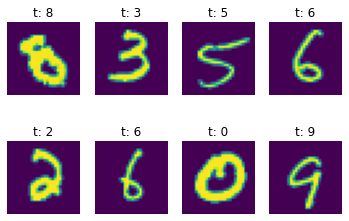

In [24]:
def plot_MNIST(images,labels):
    rows = 2
    columns = 4
    classes = ('0', '1', '2', '3',
          '4', '5', '6', '7', '8', '9')
    # plot y_score - true label (t) vs predicted label (p)
    fig2 = plt.figure()
    for i in range(8):
        fig2.add_subplot(rows, columns, i+1)
        plt.title('t: ' + classes[labels[i].cpu()])
        img = images[i] / 2 + 0.5     # this is to unnormalize the image
        img = torchvision.transforms.ToPILImage()(img.cpu())
        plt.axis('off')
        plt.imshow(img)
    plt.show()


im_batch, lab_batch=next(iter(test_loader)) # view one batch
im_batch = im_batch.to(device)
plot_MNIST(im_batch,lab_batch)

The first thing we need to do is run inference on the images without occlusion

In [25]:
# running inference on the images without occlusion

# pretrained model
outputs = net(im_batch)

# passing the outputs through softmax to interpret them as probability
outputs = nn.functional.softmax(outputs, dim = 1)

# assigning the predicted label from the maximum softmax output
prob_no_occ, pred = torch.max(outputs.data, 1)

# get the first item
prob_no_occ = prob_no_occ[0].item()

print('Predictions = ', pred,'max prob',prob_no_occ)

Predictions =  tensor([8, 3, 5, 6, 2, 5, 0, 6]) max prob 0.753532350063324


Now, let's look at the effect of zeroing (or greying out) blocks of pixels in our image.

Similar to the patch based selection that we saw in lecture 4, we are constrained to select only patches which fit in our image (which means that number of points on which we can start each patch is constrained by the width and height of our patch). This means that the output size will be smaller than the original image size by a factor of: (h-p)/s; where, h is the height (or width), p is the patch size and s is the chosen stride.

Let's start create an image with an occluded patch in the centre. 


### Ex 2.1 - Create a function which occludes a patch from an image

**Task 2.1.1.** set all pixels of patch (centred at height: `heigh_centre` and width: `width_centre`, and of size: `patch_size`) to 0.5
  - **note** if the patch_size exceeds the dimensions on any axis - just set the available space to zero (otherwise the results of Ex 3.2 will have shape less than the original image). This is equivalent to padding the operation.

In [26]:
# Write a function which occludes a patch from an image
from math import ceil

def occlude_image(image, height_centre,width_centre,patch_size):
    ''' 
    Creates a copy of the image and occludes a patch 
    input:
    image (Pytorch tensor): image to be occluded
    height_centre=centre of patch on height dimension
    width_centre= centre of patch on width dimension
    patch_size: size of patch
    
    output: 
    occluded image
    '''

    occluded_image = image.detach().clone()
    
    # estimate the start and end dimensions of the patch
    # allow for patches to be centred at all locations irrespective of whether patch fits fully or not i.e. pad
    height_start=int(height_centre-ceil(patch_size/2))
    width_start=int(width_centre-ceil(patch_size/2))

    if height_start <0:
      height_start=0
    if width_start < 0:
      width_start=0

    height_end=height_start+patch_size
    width_end=width_start+patch_size

    if height_end >= occluded_image.shape[1]:
      height_end=occluded_image.shape[1]-1
    if width_end >= occluded_image.shape[2]:
      width_end=occluded_image.shape[2]-1
    
    # Task 2.1.1 - change pixel values in patch to 0.5
    occluded_image[:,height_start:height_end,width_start:width_end]=0.5
    
    return occluded_image

**Task 2.1.2.** Pass the full image through the network and estimate the probability of the network predicting the correct label (return softmax output corresponding to the correct label)

**Task 2.1.3** Now occlude the image and make another forward pass; how does occlusion impact the prediction accuracy?

**Task 2.1.4** Return label probabilities for this prediction using softmax

**Note** 
- forward pass expects an input tensor of shape $B\times C\times H\times W$ where $B$ represents the batch size, $C$ the number of channels and $H$ and $W$ the height and width (**hint** perhaps use [unsqueeze](https://pytorch.org/docs/stable/generated/torch.unsqueeze.html))
-you will need to use `nn.functional.softmax()` on the output from your network. This will return a probability for each label (summing to one over all classes

True label: 8 original probability: 0.9549274444580078 occluded probability: 0.08304549753665924


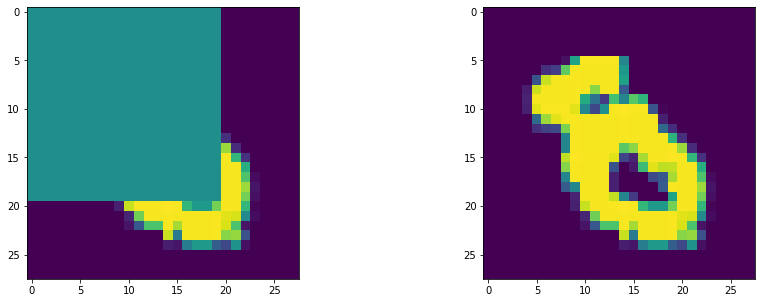

In [29]:
true_label=lab_batch[0].numpy()
patch_size=20
height_center=8
width_center=8

# Task 2.1.2 pass the image through a forward pass  and estimate the probability of prediction of the True label (2 lines)
# remember the network will be expect an input of shape BxCxHxW where B is batch size and C is number of channels
# use nn.functional.softmax to return a probability - slice the output for the true label
output_full=net(im_batch[0].unsqueeze(0))
full_prob=nn.functional.softmax(output_full,dim=1)[0,true_label]

# Task 2.1.3 pass the image through the occlusion function and make forward pass (2 lines)
occluded_image=occlude_image(im_batch[0], height_center,width_center,patch_size)
output_occluded=net(occluded_image.unsqueeze(0))

# Task 2.1.4 return label probabilities for this prediction using softmax - slice the output for the true label
occluded_prob=nn.functional.softmax(output_occluded,dim=1)[0,true_label] 

print('True label: {} original probability: {} occluded probability: {}'.format(true_label, full_prob,occluded_prob)) 

# plot
fig2 = plt.figure(figsize=(15,5))
fig2.add_subplot(1, 2, 1)
#displaying the image using seaborn heatmap and also setting the maximum value of gradient to probability
img = torchvision.transforms.ToPILImage()(occluded_image[0].cpu())
plt.imshow(img)
fig2.add_subplot(1, 2, 2)
img = torchvision.transforms.ToPILImage()(im_batch[0].cpu())
plt.imshow(img)
plt.show()

You will see that, not unexpectedly grey out the part of the image which contains the number will dramatically reduce the probability of selecting the correct label.

Thus, occlusion presents us a network indepedent way of generating a map of regional saliencies. All we need to do is **occlude patches centered at all feasible locations** in the image; then we can generate a heatmap of label probabilities estimated for each of these patches/locations. 


### Ex 2.2 - Create occlusion based saliency map

Create a function to iterate across an image to generate patch predictions at each feasible location.



In [30]:
#STUDENTS CODE -  Write a custom function to conduct occlusion experiments

def occlusion(model, image, label, occ_size = 50,  occ_pixel = 0.5):
    '''
       function to iterate occlusion mapping for all locations in an image
       in order to return a heatmap
       input:
            model - the trained model
            image - the input image to occlude
            label - the true image label
            occ_size - the patch size
            occ_pixel - the value to fill the patch with
      
      output:
           heatmap (torch array) - same shape as image,
                                 - value at each grid location =  label probabilities corresponding to result of occluding a patch centred at the corresponding image location

    '''
    #create a zero image with shape equal to the image
    heatmap = torch.zeros((image.shape[1],image.shape[2]))
    
    # Ex 2.2 - complete occlusion function
    #iterate all the pixels in each column
    for h in range(image.shape[1]):
      for w in range(image.shape[2]):
        
          # occlude image for this patch
          occluded_image=occlude_image(image, h,w,occ_size)
          # make forward pass and return softmax probability
          output_occluded=net(occluded_image.unsqueeze(0))
          occluded_prob=nn.functional.softmax(output_occluded,dim=1)[0,true_label] 
          #setting the heatmap location to probability value
          heatmap[h, w] = occluded_prob

    return heatmap



Now run for the test image - you may need to change the patch size to get an interpretable result

In [31]:
print(pred[0],pred[0].type)
image=im_batch[0]
heatmap = occlusion(net, image, lab_batch[0].item(),20, 1)
print(torch.max(heatmap))

tensor(8) <built-in method type of Tensor object at 0x7f406f7e2180>
tensor(0.9978, grad_fn=<MaxBackward1>)


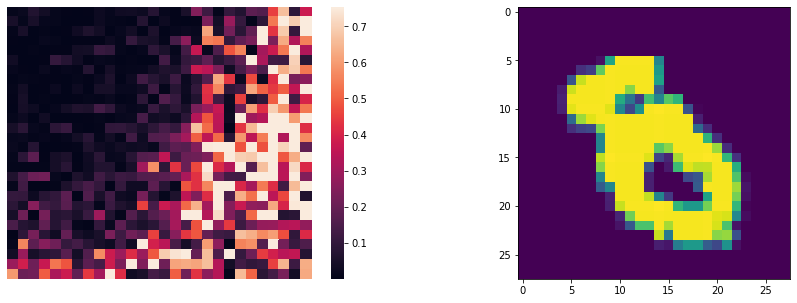

In [32]:
import seaborn as sns

fig2 = plt.figure(figsize=(15,5))
fig2.add_subplot(1, 2, 1)
#displaying the image using seaborn heatmap and also setting the maximum value of gradient to probability
imgplot = sns.heatmap(heatmap.detach().numpy(), xticklabels=False, yticklabels=False, vmax=prob_no_occ)
figure = imgplot.get_figure()    
fig2.add_subplot(1, 2, 2)
img = torchvision.transforms.ToPILImage()(image[0].cpu())
plt.imshow(img)
plt.show()

## Exercise 3: Gradient visualization with Guided backpropagation

So occlusion can be an effective method for returning saliency maps but for large images it can be computationally costly compute. Therefore several alternative methods have been proposed which instead seek to backpropagate gradients from output neurons to the locations in the image which contribute most significantly to the prediction. 

The first method we will look at will be Guided Backpropation, which is an extension of DeconvNet to generalise to all convolutional networks (which downsample through strided convolutions). The Deconvnet visualises activations pertaining to specific classes, by pushing gradient activations backwards from through the network through a series of unpooling, relus (to zero negative gradients) and inverse convolutions (implemented by applying transposed filters)

For [Guided Backpropagation](https://arxiv.org/pdf/1412.6806.pdf), the outputs of relu operations at each layer are pushed backwards, guided by masks which summarise the forwards and backwards relu. Thus these zero contributions from any locations with negative activations or negative gradients to return locations in the image that contribute positively to the prediction.

<figure align="center">
<img src="https://github.com/IS-pillar-3/miscellaneous/blob/main/guided_backprop.png?raw=True" alt="Drawing" width="800px;"/>
</figure>

You can find the implementation of guided backpropagation in the `vizualizations` package folder that you uploaded to run this notebook `/visualizations/src/guided_backprop.py`.

### Ex 3.1 - first comment each line in `GuidedBackprop.update_relus(self)`

To cement your understanding of the Guided Backpropagation method, comment each line of the function `GuidedBackprop.update_relus(self)`. This uses hooks to extract the activations and gradients of each relu layer. These are used to mask the relu gradients and push them back towards the input pixel space.




**Now, run guided backpropagation for a given input image.**

The `visualizations` package is specifically designed to visualise the layers of PyTorch pretrained networks. Thus the function `misc_functions.get_example_params()` function loads a pretrained AlexNet and returns a preprocessed image `prep_img`,as well as it's target label.

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 3, 224, 224]) (224, 224, 3)


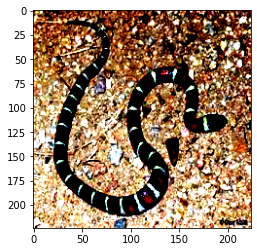

In [33]:
target_example = 0  
(original_image, prep_img, target_class, file_name_to_export, pretrained_model) =\
    get_example_params(target_example)

im_array=prep_img[0].detach().numpy()
print(prep_img.shape,np.moveaxis(im_array, 0, -1).shape)
plt.imshow(np.moveaxis(im_array, 0, -1))
plt.show()

An instance of the guidedbackprop class can be created using:

In [34]:
GBP = GuidedBackprop(pretrained_model)

Gradients specific to a particular input image, and class may be generated using the method `GP.generate_gradients()`, which has the following steps:
 1. go through a forward pass with the image input, and generate an output
 2. backprop through the output
 3. get the gradients from the backprop
 
**Run:**

In [35]:
# Get gradients
guided_grads = GBP.generate_gradients(prep_img, target_class)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


We can then plot the outputs. Note for RGB matplot lib expects channels on the 3rd axis so we need to reshape:

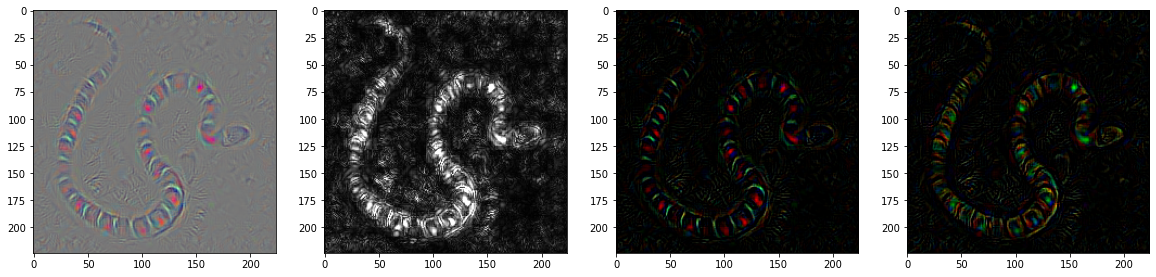

In [36]:
# Convert to grayscale
grayscale_guided_grads = convert_to_grayscale(guided_grads)
# Positive and negative saliency maps
pos_sal, neg_sal = get_positive_negative_saliency(guided_grads)

### return normalise gradients and plot
guided_grads=normalise_gradient(guided_grads)
grayscale_guided_grads=normalise_gradient(grayscale_guided_grads)
pos_sal=normalise_gradient(pos_sal)
neg_sal=normalise_gradient(neg_sal)

fig2 = plt.figure(figsize=(20,10))
fig2.add_subplot(1, 4,1)
plt.imshow(np.moveaxis(guided_grads, 0, -1))
fig2.add_subplot(1, 4,2)
plt.imshow(grayscale_guided_grads[0],cmap='gray')
fig2.add_subplot(1, 4,3)
plt.imshow(np.moveaxis(pos_sal, 0, -1))
fig2.add_subplot(1, 4,4)
plt.imshow(np.moveaxis(neg_sal, 0, -1))
plt.show()


### Ex 3.2 - Run guided backprop for different inputs
You can do this by changing `target_example=` (there's 3 inputs available)

torch.Size([1, 3, 224, 224]) (224, 224, 3)


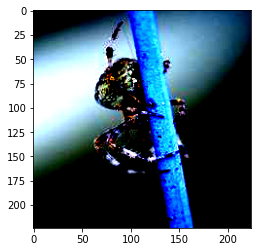

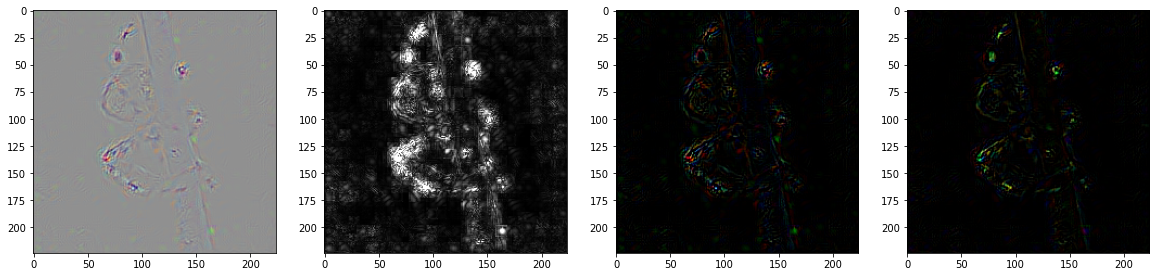

In [38]:
# TASK - change target example:
target_example = 2

(original_image, prep_img, target_class, file_name_to_export, pretrained_model) =\
    get_example_params(target_example)

im_array=prep_img[0].detach().numpy()
print(prep_img.shape,np.moveaxis(im_array, 0, -1).shape)
plt.imshow(np.moveaxis(im_array, 0, -1))
plt.show()

# Get gradients 
guided_grads = GBP.generate_gradients(prep_img, target_class)

# Convert to grayscale
grayscale_guided_grads = convert_to_grayscale(guided_grads)
# Positive and negative saliency maps
pos_sal, neg_sal = get_positive_negative_saliency(guided_grads)

### return normalise gradients and plot
guided_grads=normalise_gradient(guided_grads)
grayscale_guided_grads=normalise_gradient(grayscale_guided_grads)
pos_sal=normalise_gradient(pos_sal)
neg_sal=normalise_gradient(neg_sal)

fig2 = plt.figure(figsize=(20,10))
fig2.add_subplot(1, 4,1)
plt.imshow(np.moveaxis(guided_grads, 0, -1))
fig2.add_subplot(1, 4,2)
plt.imshow(grayscale_guided_grads[0],cmap='gray')
fig2.add_subplot(1, 4,3)
plt.imshow(np.moveaxis(pos_sal, 0, -1))
fig2.add_subplot(1, 4,4)
plt.imshow(np.moveaxis(neg_sal, 0, -1))
plt.show()

## Exercise 4: Gradient Class Activation Mapping (grad-CAM)


[Grad-cam](https://arxiv.org/abs/1610.02391) allows extraction of occlusion-like saliency maps in a single pass, by creating a neuron importance score for a given target class. 

<figure align="center">
<img src="https://github.com/IS-pillar-3/miscellaneous/blob/main/gradcam.png?raw=True" alt="Drawing" width="800px;"/>
</figure>

Specifically, it makes a forward pass, estimates the gradient of output activation ($A^k$), before the softmax and with respect to the target class ($y^c$), clamps this to one and then sets the gradient for all other classes to zero. It then estimates a **neuron importance score** by global average pooling over the spatial dimensions ($i,j$) of the channel:

$$\alpha_k^c=\frac{1}{Z} \sum_i \sum_j \dfrac{\partial y^c}{\partial A^k_{ij}}$$

This summarises the importance of a particular featuremap or channel to the prediction.

The final $\mathbb{R}^{u \times v}$ visualisation is then estimated from a weighted average over all activation map (where weights are given by the neuron importance scores). This is followed by a ReLU to clamp the visualisation to return only positive contributions. 

$$L^C_{Grad\_cam}=RELU(\sum_k \alpha_k^c A^k)$$

### Ex 4.1 - Apply the code

Run grad cam on the same examples used for Guided Backprop. What key differences do you observe.

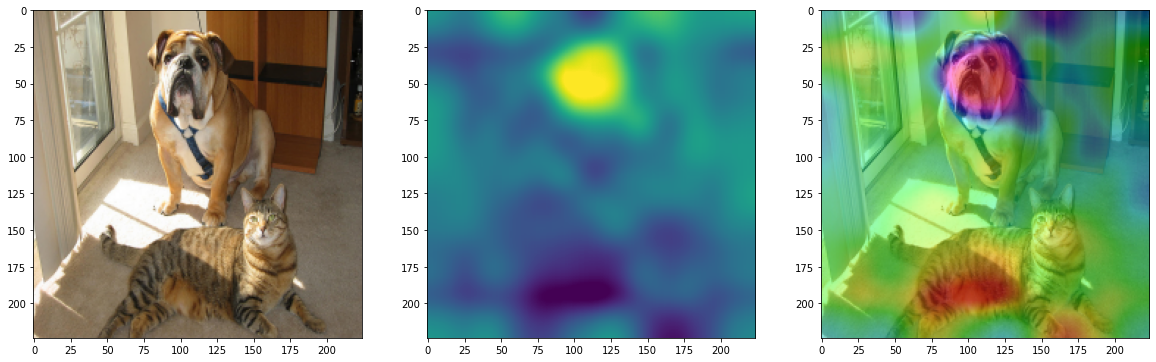

In [39]:
# Get params
target_example = 1
(original_image, prep_img, target_class, file_name_to_export, pretrained_model) =\
    get_example_params(target_example)

# Grad cam
grad_cam = GradCam(pretrained_model, target_layer=11)
# Generate cam mask
cam = grad_cam.generate_cam(prep_img, target_class)

# Create Grayscale activation map
heatmap, heatmap_on_image = apply_colormap_on_image(original_image, cam, 'hsv')

# plot
fig_cam = plt.figure(figsize=(20,10))
fig_cam.add_subplot(1, 3,1)
plt.imshow(original_image)
fig_cam.add_subplot(1, 3,2)
plt.imshow(cam)
fig_cam.add_subplot(1, 3,3)
plt.imshow(heatmap_on_image)

**Note** `target_example` is a picture of a dog and a cat but the `get_example_params` is hard coded to dog. If you would like to try different pictures the imagenet class label list can be found [here](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a)

### Ex 4.2 - Change the class of the image to 'tabby cat'

You might also want to chose other images, or vary the target layer.

In [ ]:
# Ex 4.2 - run grad cam for but change class of image to tabby cat
img_path = './visualizations/input_images/cat_dog.png'

target_class=280

original_image = Image.open(img_path).convert('RGB')
print(original_image.size,type(original_image))
prep_img = preprocess_image(original_image)

# Grad cam
grad_cam = GradCam(pretrained_model, target_layer=9)
# Generate cam mask
cam = grad_cam.generate_cam(prep_img, target_class)

## Create Grayscale activation map
heatmap, heatmap_on_image = apply_colormap_on_image(original_image, cam, 'hsv')

# plot
fig_cam = plt.figure(figsize=(20,10))
fig_cam.add_subplot(1, 3,1)
plt.imshow(original_image)
fig_cam.add_subplot(1, 3,2)
plt.imshow(cam)
fig_cam.add_subplot(1, 3,3)
plt.imshow(heatmap_on_image)

## Exercise 5: T-SNE

Experiment with t-sne using the [scikit-learn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). In its most basic form this can be done in one line

```
>>> import numpy as np
>>> from sklearn.manifold import TSNE
>>> X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
>>> X_embedded = TSNE(n_components=2, learning_rate='auto',
...                   init='random', perplexity=3).fit_transform(X)
>>> X_embedded.shape
(4, 2)
```




For this exercise we will again use the data from the first session "prem_vs_termwrois.pkl". This represents mean vales of three different types of cortical imaging data: cortical thickness, cortical folding and cortical myelination, all averaged within 100 regions of interest ROIS on the surface (300 features in total). There are 101 babies, 50 terms and 51 preterms. 

<figure align="center">
<img src="https://github.com/IS-pillar-3/miscellaneous/blob/main/cortical_rois.png?raw=True" alt="Drawing" width="900px;"/>
</figure>

**To do**

**Ex 5.1.** implement t-sne using scikit learn. Set `n_components=2`; fit the embedding for the dHCP data

**Ex 5.2** experiment with changing the perplexity n to the range 5 to 50

**Ex 5.3** experiment with changing the metric to other options available through [scipy.spatial.distance.pdista](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html) (to e.g. correlation)

**Ex 5.4** In each instance, plot the embedding with the points color coded by label (pre-term vs full-term)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


(101, 2)


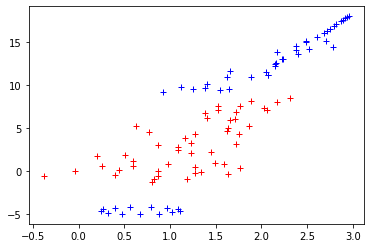

In [12]:
import pandas as pd
from sklearn import manifold
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import copy
import requests
import io

url      = "https://raw.githubusercontent.com/IS-pillar-3/datasets/main/prem_vs_termwrois.csv" 
download = requests.get(url).content
df       = pd.read_csv(io.StringIO(download.decode("utf-8")))

# Read the data
data = df.values[:,:-2]
y = df.values[:,-1]

# Ex 5.1
perplexity=25

tsne = manifold.TSNE(n_components=2, init='random',random_state=0, metric='correlation', perplexity=perplexity)

Y = tsne.fit_transform(data)

print(Y.shape)

plt.plot(Y[y==1,0],Y[y==1,1],'b+')
plt.plot(Y[y==0,0],Y[y==0,1],'r+')

**Source references**

1. [visualizing-convolution-neural-networks-using-pytorch](https://towardsdatascience.com/visualizing-convolution-neural-networks-using-pytorch-3dfa8443e74e)
2. [DeepLearning-PadhAI](https://colab.research.google.com/github/Niranjankumar-c/DeepLearning-PadhAI/blob/master/DeepLearning_Materials/6_VisualizationCNN_Pytorch/CNNVisualisation.ipynb#scrollTo=uQI9jHcP6xfP)